In [1]:
import networkx as nx
from parse import read_input_file, write_output_file
from utils import is_valid_network, average_pairwise_distance, average_pairwise_distance_fast
import sys
from collections import defaultdict
import solver_trimMST as trimMST

In [2]:
def solve(G):
    """
    Args:
        G: networkx.Graph

    Returns:
        T: networkx.Graph
    """
    min_tree = nx.Graph()
    min_cost = float('inf')

    # if by luck there's a node connecting to all other verts, return it 
    for node in G.nodes:
        if len(list(nx.neighbors(G, node))) == nx.number_of_nodes(G) - 1:
            min_tree.add_node(node)
            return min_tree

    start_vertices = starting_point(G)

    # run greedy alg on all starting vertex candidates
    for start_vertex in start_vertices:
        curr_tree = ds_spt(G, start_vertex)
        curr_cost = average_pairwise_distance_fast(curr_tree)
        if curr_cost < min_cost:
            min_cost = curr_cost
            min_tree = curr_tree

    return min_tree

# vertices w more than n*DENSE_THRESHOLD neighbors is considered dense
DENSE_THRESHOLD = 0.75
SPARSE_THRESHOLD = 0.25

def starting_point(G):
    """ 
    picks starting point depending on sparcity of graph
    """
    result = []
    # (node, degree) pairs
    all_degrees = G.degree(G.nodes)
    
    # maps from degree to list of nodes w that degree
    deg_to_nodes = defaultdict(list)
    for node, deg in all_degrees:
        deg_to_nodes[deg].append(node)
        
    max_deg = max(deg_to_nodes)
    min_deg = min(deg_to_nodes)

    # include sparse nodes
    if min_deg <= (len(G) * SPARSE_THRESHOLD):
        if min_deg == 1:
            leaf = deg_to_nodes[min_deg][0] # could optimize this more
            leaf_neighbor = list(G[leaf])[0] 
            result.append(leaf_neighbor)  
        else:
            result.append(deg_to_nodes[min_deg][0])

    # include dense nodes
    if max_deg >= (len(G) * DENSE_THRESHOLD):
        result.append(deg_to_nodes[max_deg][0])  # could optimize this more
    # if there's neither dense nor sparse nodes, default to starting at densest node
    else:
        result.append(deg_to_nodes[max_deg][0])

    return result

def ds_spt(G, start_node):
    """
    find a dominating set, from which we construct a subgraph by the 
    union of all pairwise shortest paths.
    then run trimMST on the subgraph.
    """
    subgraph = nx.Graph()
    ds = nx.dominating_set(G, start_node)
    #print(ds)
    subgraph.add_nodes_from(ds)

    shortest_paths = nx.all_pairs_dijkstra_path(G)
    shortest_paths = dict(shortest_paths)

    # add all edges/nodes in shortest paths to subgraph
    for source in ds:
        for target in ds:
            if source != target:
                # path is a list of nodes along the s-t path
                path = shortest_paths[source][target]
                for i in range(len(path) - 1):
                    node_from = path[i]
                    node_to = path[i+1]
                    weight = G[node_from][node_to]['weight']
                    if not subgraph.has_node(node_from):
                        subgraph.add_node(node_from)
                    if not subgraph.has_node(node_to):
                        subgraph.add_node(node_to)
                    if not subgraph.has_edge(node_from, node_to):
                        subgraph.add_edge(node_from, node_to, weight=weight)
                        
    nx.draw(subgraph, with_labels=True)
    tree = trimMST.solve(subgraph)
    #tree = nx.minimum_spanning_tree(subgraph)
    return tree

In [3]:
filenum = "161"
path = "./inputs/small-{}.in".format(filenum)
G = read_input_file(path)
T = solve(G)

/Users/cynthiazhong/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


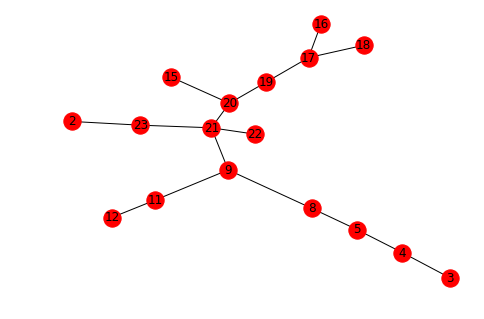

In [4]:
nx.draw(T, with_labels=True)

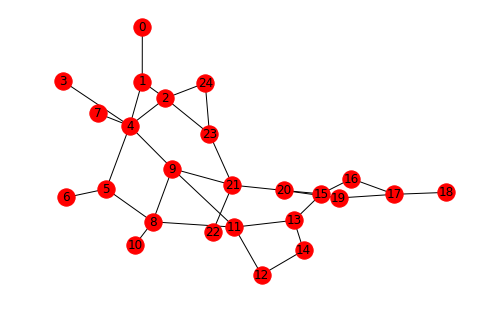

In [5]:
nx.draw(G, with_labels=True)

In [6]:
nx.is_dominating_set(G, T.nodes)

False

In [7]:
nx.is_tree(T)

True